# Model selection for Emoji-predictors for Spanish tweets
Author: Eric S. Tellez -- [donsadit@gmail.com](mailto:donsadit@gmail.com)

## Abstract
This scripts shows how to evaluate the percreate a text model and a classifier that predicts the related emoji for a given short text.
The text model can be a classifical TFIDF model or an Entropy based weighting; we can reduce the size of the model using prunning techniques.
This example uses a linear SVM (LIBLINEAR.jl).

## Example


The first step is to initialize the environment

In [1]:
using Pkg
pkg"activate ."
# uncomment to install the required packages
# pkg"add https://github.com/sadit/SimilaritySearch.jl https://github.com/sadit/TextSearch.jl https://github.com/sadit/KernelMethods.jl LIBLINEAR Random StatsBase CSV DataFrames StatsPlots"
using SimilaritySearch, TextSearch, LIBLINEAR, Random, StatsBase, KernelMethods, CSV, DataFrames, StatsPlots

# fetching data
url = "http://ingeotec.mx/~sadit/emotions.csv"
!isfile(basename(url)) && download(url, basename(url))
db = DataFrame(CSV.read(basename(url)))

Activating environment at `~/Research/TextSearch.jl/examples/Project.toml`


,klass,text
,String,String
1,😰,@DanuFSanz Me gustaría amika pero tengo una panza enorme _emo_
2,😥,"Debería de estar en mi casa, no aquí sufriendo porque no hay luz _emo_"
3,😊,@PowerMusicRadio _emo_ Voto X #HayAmores de @julionalvarez para que ingrese en él #TopPower con @yuyu_perez @NoticiasJulion @ViejonasJAySNB
4,♡,@CelopanYT Muy buenos días bae _emo_
5,💔,"@IsamarPortilla Gracias no era necesario, después de que me rompes el corazón _emo_"
6,🙂,Buena idea venir a mis trámites donde hubiera mi gym pa desestresarme! _emo_ (at @SmartFit_mex) _url_ _url_
7,😋,Lasaña!!!. _emo_ _emo_ _emo_ @ Postodoro Xalapa Centro _url_
8,😊,Hay que aprender a vivir nuestra vida y dejar a los demás vivir la suya _emo_
9,♡,Tu por siempre _emo_ _url_


## Partitioning the data

We take a small sample for training and validation collections to estimate the performance of our predictions; here we use a siholdout scheme for cross-validation.

In [2]:
function sample_and_partition(db, n, p=0.7)
    m = round(Int, n * p)
    G = db[sample(1:size(db, 1), n), :]
    corpus_train = G.text[1:m]
    corpus_test = G.text[m+1:end]
    labels_train = G.klass[1:m]
    labels_test = G.klass[m+1:end]
    le = fit(LabelEncoder, labels_train)
    labels_train = KernelMethods.transform.(le, labels_train)
    labels_test = KernelMethods.transform.(le, labels_test)

    (corpus_train=corpus_train, labels_train=labels_train, corpus_test=corpus_test, labels_test=labels_test, le=le)
end


sample_and_partition (generic function with 2 methods)

## The experiments
The following functions runs and evaluate the model for a small grid of parameters; the TextConfig struct is not varied to simplify the problem.

In [3]:

function model_selection_grid_search(config, db)
    part = sample_and_partition(db, 2000, 0.7)
    model_ = fit(VectorModel, config, part.corpus_train)
    L = []
    for p in [1.0, 0.9, 0.7, 0.5, 0.3, 0.1], kind=[IdfModel, FreqModel]
        model = prune_select_top(model_, p, kind)
        for vkind=[IdfModel, FreqModel, TfModel, TfidfModel]
            Xtrain = [vectorize(model, vkind, text) for text in part.corpus_train]
            Xtest = [vectorize(model, vkind, text) for text in part.corpus_test]

            for C in [10.0, 1.0, 0.1, 0.01]
                classifier = linear_train(part.labels_train, hcat(Xtrain...), C=C)
                predictions, decision_values = linear_predict(classifier, hcat(Xtest...))
                accuracy = mean(part.labels_test .== predictions)
                push!(L, (p=p, kind=string(kind), vkind=string(vkind), C=C, accuracy=accuracy, voc=length(model.tokens)))
                display(L[end])
            end
            
        end
    end
    L
end


model_selection_grid_search (generic function with 1 method)

In [4]:
config = TextConfig(qlist=[3, 5], nlist=[1], group_emo=true)
perfname = string("perf-grid-search-", replace(basename(url), r"\..+" => ""), ".csv")

if isfile(perfname)
    gs = CSV.read(perfname) |> DataFrame
else
    gs = DataFrame(model_selection_grid_search(config, db))
    CSV.write(perfname, gs)
end

display("text/html", "number of configurations: $(size(gs, 1))")
gs

number of configurations: 192

,p,kind,vkind,C,accuracy,voc
,Float64,String,String,Float64,Float64,Int64
1,1.0,IdfModel,IdfModel,10.0,0.243333,44304
2,1.0,IdfModel,IdfModel,1.0,0.25,44304
3,1.0,IdfModel,IdfModel,0.1,0.243333,44304
4,1.0,IdfModel,IdfModel,0.01,0.241667,44304
5,1.0,IdfModel,FreqModel,10.0,0.233333,44304
6,1.0,IdfModel,FreqModel,1.0,0.236667,44304
7,1.0,IdfModel,FreqModel,0.1,0.223333,44304
8,1.0,IdfModel,FreqModel,0.01,0.16,44304
9,1.0,IdfModel,TfModel,10.0,0.233333,44304


# Looking for the best configuration families
The following figures show the accuracy performance of `kind` and `vkind` parameters

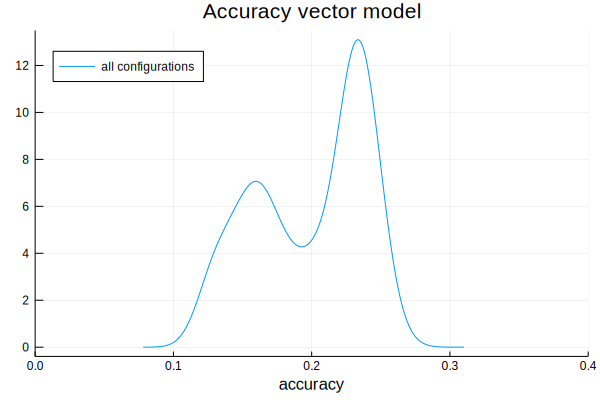

## Segmenting performance by `kind` parameter

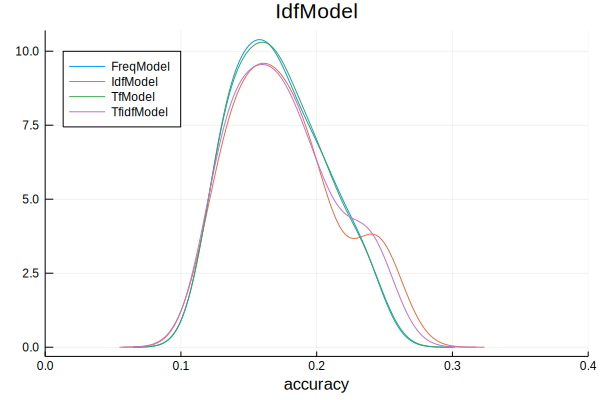

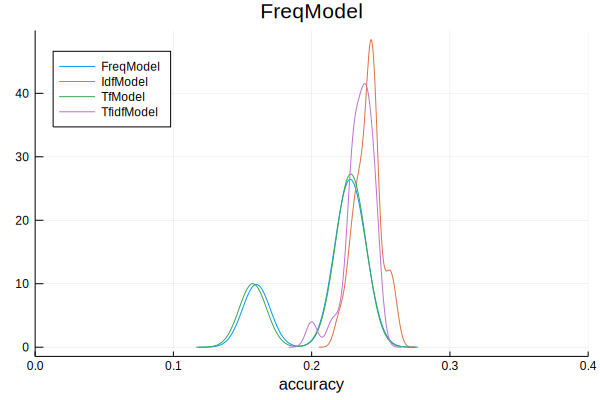

In [24]:
gsIdf = gs[gs.kind .== "IdfModel", :]
gsFreq = gs[gs.kind .== "FreqModel", :]
@df gs density(:accuracy, title="Accuracy vector model", label="all configurations", xlim=(0.,0.4), legend = :topleft, xlabel="accuracy") |> display

display("text/markdown", "## Segmenting performance by `kind` parameter")
@df gsIdf density(:accuracy, group = :vkind, title="IdfModel", legend = :topleft, xlim=(0.,0.4), xlabel="accuracy") |> display
@df gsFreq density(:accuracy, group = :vkind, title="FreqModel", legend = :topleft, xlim=(0.,0.4), xlabel="accuracy") |> display


## Looking for specially performing configurations with relatively small vocabularies
From a practical perspective, the most interesting configurations are those describing simple models that excels in accuracy performance.

The performance of `FreqModel` distributes as follows (segmented by `p`):

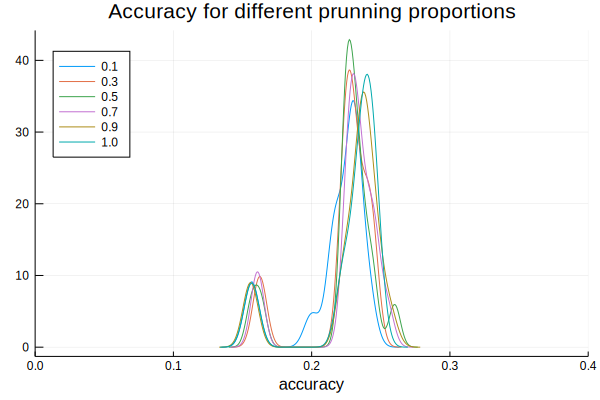

,p,kind,vkind,C,accuracy,voc
,Float64,String,String,Float64,Float64,Int64
1,0.5,FreqModel,IdfModel,1.0,0.26,22152
2,0.9,FreqModel,IdfModel,1.0,0.256667,39873
3,0.7,FreqModel,IdfModel,1.0,0.255,31012
4,1.0,FreqModel,IdfModel,1.0,0.248333,44304
5,0.9,FreqModel,TfidfModel,1.0,0.248333,39873
6,1.0,FreqModel,TfidfModel,1.0,0.246667,44304
7,0.7,FreqModel,IdfModel,0.1,0.246667,31012
8,0.9,FreqModel,IdfModel,10.0,0.245,39873
9,0.9,FreqModel,IdfModel,0.1,0.245,39873


When $p$ is limited to describe small vocabularies

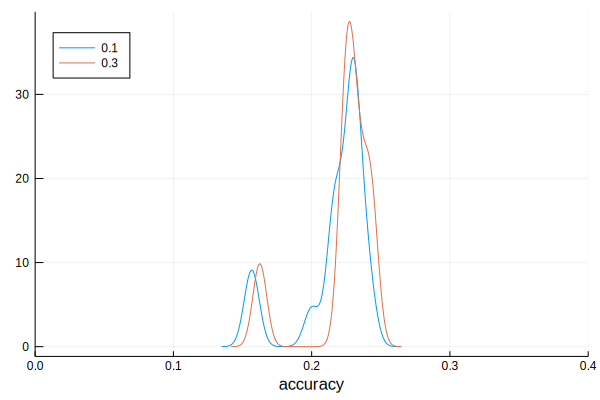

,p,kind,vkind,C,accuracy,voc
,Float64,String,String,Float64,Float64,Int64
1,0.3,FreqModel,TfidfModel,1.0,0.245,13291
2,0.3,FreqModel,TfidfModel,10.0,0.243333,13291
3,0.3,FreqModel,IdfModel,1.0,0.241667,13291
4,0.1,FreqModel,IdfModel,1.0,0.241667,4430
5,0.3,FreqModel,IdfModel,0.1,0.24,13291
6,0.1,FreqModel,IdfModel,0.1,0.238333,4430
7,0.3,FreqModel,TfidfModel,0.1,0.235,13291
8,0.3,FreqModel,IdfModel,10.0,0.233333,13291
9,0.1,FreqModel,FreqModel,1.0,0.231667,4430


In [6]:
# @df gsIdf density(:accuracy, group = (:vkind, :p), legend = :topleft, xlim=(0.,0.1), ylim=(-5, 300)) |> display
@df gsFreq density(:accuracy, group = (:p), title="Accuracy for different prunning proportions", legend = :topleft, xlim=(0., 0.4), xlabel="accuracy") |> display
first(sort!(gsFreq, :accuracy, rev=true), 10) |> display

display("text/markdown", raw"When $p$ is limited to describe small vocabularies")
gsFreqSmall = gsFreq[gsFreq.p .<= 0.3, :]
@df gsFreqSmall density(:accuracy, group = (:p),  xlim=(0., 0.4), legend = :topleft, xlabel="accuracy") |> display
first(sort!(gsFreqSmall, :accuracy, rev=true), 10) |> display

# Best performing configurations

To answer the question of what configurations performs better, we need to validate that our estimation
is precise and follows the reality. This a costly procedure, and therefore, we suppose that the estimation-process performs *well*,
such that we only need to evaluate top-k better-models.

In [7]:
first(sort!(gs, :accuracy, rev=true), 10) |> display

,p,kind,vkind,C,accuracy,voc
,Float64,String,String,Float64,Float64,Int64
1,0.5,FreqModel,IdfModel,1.0,0.26,22152
2,0.9,FreqModel,IdfModel,1.0,0.256667,39873
3,0.7,FreqModel,IdfModel,1.0,0.255,31012
4,1.0,IdfModel,IdfModel,1.0,0.25,44304
5,1.0,FreqModel,IdfModel,1.0,0.248333,44304
6,0.9,FreqModel,TfidfModel,1.0,0.248333,39873
7,1.0,IdfModel,TfidfModel,1.0,0.246667,44304
8,1.0,FreqModel,TfidfModel,1.0,0.246667,44304
9,0.7,FreqModel,IdfModel,0.1,0.246667,31012


The following code evaluates top $k$ configurations and also compares with a random selection. 

In [18]:
function evaluate_model(part, p, kind, vkind, C)
    model_ = fit(VectorModel, config, part.corpus_train)
    model = prune_select_top(model_, p, kind)
    Xtrain = [vectorize(model, vkind, text) for text in part.corpus_train]
    Xtest = [vectorize(model, vkind, text) for text in part.corpus_test]
    classifier = linear_train(part.labels_train, hcat(Xtrain...), C=C)
    predictions, decision_values = linear_predict(classifier, hcat(Xtest...))    
    accuracy = mean(part.labels_test .== predictions)
    (p=p, kind=kind, vkind=vkind, C=C, accuracy=accuracy, voc=length(model.tokens))
end


begin
    perfname = string("perf-top-global-", replace(basename(url), r"\..+" => ""), ".csv")
    perfsmallname = string("perf-top-small-", replace(basename(url), r"\..+" => ""), ".csv")
    perfrandname = string("perf-top-random-", replace(basename(url), r"\..+" => ""), ".csv")

    part_large = nothing
    topk = 10
    
    if isfile(perfsmallname)
        top_small = CSV.read(perfsmallname) |> DataFrame
    else
        L = []
        part_large = sample_and_partition(db, size(db, 1), 0.7)
        for row in eachrow(first(sort!(gsFreqSmall, :accuracy, rev=true), topk))
            e = evaluate_model(part_large, row.p, eval(Symbol(row.kind)), eval(Symbol(row.vkind)), row.C)
            push!(L, e)
            @show e
        end
        
        top_small = DataFrame(L)
        CSV.write(perfsmallname, top_small)
    end
    
    if isfile(perfname)
        top = CSV.read(perfname) |> DataFrame
    else
        L = []
        if part_large === nothing
            part_large = sample_and_partition(db, size(db, 1), 0.7)
        end
        
        for row in eachrow(first(sort!(gs, :accuracy, rev=true), topk))
            e = evaluate_model(part_large, row.p, eval(Symbol(row.kind)), eval(Symbol(row.vkind)), row.C)
            push!(L, e)
            @show e
        end

        top = DataFrame(L)
        CSV.write(perfname, top)
    end
    
    if isfile(perfrandname)
        toprand = CSV.read(perfrandname) |> DataFrame
    else
        L = []
        if part_large === nothing
            part_large = sample_and_partition(db, size(db, 1), 0.7)
        end
        
        
        for row in rand(eachrow(gs) |> collect, topk)
            e = evaluate_model(part_large, row.p, eval(Symbol(row.kind)), eval(Symbol(row.vkind)), row.C)
            push!(L, e)
            @show e
        end

        toprand = DataFrame(L)
        CSV.write(perfrandname, toprand)
    end   
end

fitting VectorModel with 8765 items
xxxxxxxxfinished VectorModel: 8765 processed items, voc-size: 111559


e = (p = 0.5, kind = IdfModel, vkind = FreqModel, C = 0.1, accuracy = 0.4429065743944637, voc = 55779)


fitting VectorModel with 8765 items
xxxxxxxxfinished VectorModel: 8765 processed items, voc-size: 111559


e = (p = 1.0, kind = IdfModel, vkind = TfModel, C = 1.0, accuracy = 0.5701357466063348, voc = 111559)


fitting VectorModel with 8765 items
xxxxxxxxfinished VectorModel: 8765 processed items, voc-size: 111559


e = (p = 1.0, kind = IdfModel, vkind = TfModel, C = 10.0, accuracy = 0.5751929731168486, voc = 111559)


fitting VectorModel with 8765 items
xxxxxxxxfinished VectorModel: 8765 processed items, voc-size: 111559


e = (p = 0.3, kind = FreqModel, vkind = IdfModel, C = 10.0, accuracy = 0.5778546712802768, voc = 33467)


fitting VectorModel with 8765 items
xxxxxxxxfinished VectorModel: 8765 processed items, voc-size: 111559


e = (p = 0.9, kind = IdfModel, vkind = TfModel, C = 0.01, accuracy = 0.5288794250731967, voc = 100403)


fitting VectorModel with 8765 items
xxxxxxxxfinished VectorModel: 8765 processed items, voc-size: 111559


e = (p = 0.3, kind = IdfModel, vkind = IdfModel, C = 0.1, accuracy = 0.34016502528613257, voc = 33467)


fitting VectorModel with 8765 items
xxxxxxxxfinished VectorModel: 8765 processed items, voc-size: 111559


e = (p = 0.7, kind = IdfModel, vkind = TfidfModel, C = 0.1, accuracy = 0.48682459409103007, voc = 78091)


fitting VectorModel with 8765 items
xxxxxxxxfinished VectorModel: 8765 processed items, voc-size: 111559


e = (p = 0.3, kind = IdfModel, vkind = TfidfModel, C = 0.01, accuracy = 0.34096353473516106, voc = 33467)


fitting VectorModel with 8765 items
xxxxxxxxfinished VectorModel: 8765 processed items, voc-size: 111559


e = (p = 1.0, kind = IdfModel, vkind = FreqModel, C = 0.1, accuracy = 0.44450359329252065, voc = 111559)


fitting VectorModel with 8765 items
xxxxxxxxfinished VectorModel: 8765 processed items, voc-size: 111559


e = (p = 0.5, kind = FreqModel, vkind = FreqModel, C = 10.0, accuracy = 0.5754591429331913, voc = 55779)


"perf-top-random-emotions.csv"

This behavior is illustrated in the following figure:

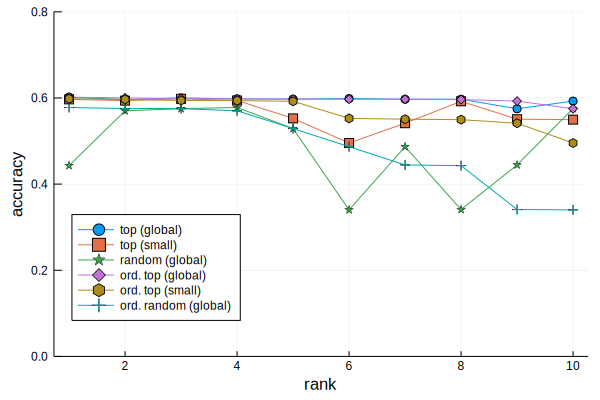

In [19]:
plot(top.accuracy, label="top (global)", ylim=(0, 0.8), legend=:bottomleft, xlabel="rank", ylabel="accuracy", markershape=:auto)
plot!(top_small.accuracy, label="top (small)", markershape=:auto)
plot!(toprand.accuracy, label="random (global)", markershape=:auto)

plot!(sort(top.accuracy, rev=true), label="ord. top (global)", markershape=:auto)
plot!(sort(top_small.accuracy, rev=true), label="ord. top (small)", markershape=:auto)
plot!(sort(toprand.accuracy, rev=true), label="ord. random (global)", markershape=:auto)

# Conclusions

We can observe from the last figure that top global and top small perform pretty similar, which is good since small models have many practical advantages. On the other hand, performingg random selection instead of a large grid search may be desirable. For instance, the evaluation of 10 random configurations evaluates 0.57 of accuracy for a 0.6 of the best performing configuration in the full grid search, using just a small fraction of the computing time. It should be interesting to determine if restricting the random searrch to models with small vocabulary can achieve such better performances with a small time cost.